In [1]:
import os
import numpy as np
import pandas as pd

import rasterio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from datetime import datetime

In [ ]:
# 🔧 Update this path to match your TIFF directory
folder = "../Datasets/VNP46A2_AllBands_Nov2013/"
file_list = sorted([f for f in os.listdir(folder) if f.endswith(".tif")])

In [ ]:
# 🔧 Path to your TIFF file
tiff_path = "../Datasets/VNP46A2_AllBands_Nov2013/VNP46A2_Region8_20131110.tif"

# Band names in order of appearance (7 bands)
band_names = [
    'DNB_BRDF_Corrected_NTL',
    'DNB_Lunar_Irradiance',
    'Gap_Filled_DNB_BRDF_Corrected_NTL',
    'Latest_High_Quality_Retrieval',
    'Mandatory_Quality_Flag',
    'QF_Cloud_Mask',
    'Snow_Flag'
]

# 📊 Read and summarize each band
summaries = []

with rasterio.open(tiff_path) as src:
    data = src.read()  # shape: (bands, height, width)

    for i, band_array in enumerate(data):
        band_name = band_names[i]
        flat = band_array.flatten()

        # Remove NaNs and Fill Values (255 for some flags)
        clean = flat[~np.isnan(flat)]
        if band_name == "Mandatory_Quality_Flag":
            clean = clean[clean != 255]

        stats = {
            "Band": band_name,
            "Min": np.nanmin(clean),
            "Max": np.nanmax(clean),
            "Mean": np.nanmean(clean),
            "Median": np.nanmedian(clean),
            "Std": np.nanstd(clean),
            "Valid Pixels": np.count_nonzero(~np.isnan(clean)),
            "Total Pixels": flat.size
        }

        summaries.append(stats)

# ⬇️ Output as DataFrame
df_summary = pd.DataFrame(summaries)
print(df_summary)

In [51]:
import os
import numpy as np
import pandas as pd
import rasterio

# 🔧 Update this to your TIFF folder path
folder = "../Datasets/VNP46A2_AllBands_Nov2013/"

# Band names based on native TIFF order
band_names = [
    'DNB_BRDF_Corrected_NTL',
    'DNB_Lunar_Irradiance',
    'Gap_Filled_DNB_BRDF_Corrected_NTL',
    'Latest_High_Quality_Retrieval',
    'Mandatory_Quality_Flag',
    'QF_Cloud_Mask',
    'Snow_Flag'
]

all_stats = []

# List TIFF files
tif_files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])

# Loop over each file
for fname in tif_files:
    path = os.path.join(folder, fname)
    date = fname[-12:-4]  # assumes 'VNP46A2_YYYYMMDD.tif'

    with rasterio.open(path) as src:
        bands = src.read()
        mask = bands[5]  # Assume QF_Cloud_Mask is always non-NaN in masked area
        valid_mask = ~np.isnan(mask)

        for i, band in enumerate(bands):
            band_name = band_names[i]
            band_data = band.astype(np.float32)
            band_data[~valid_mask] = np.nan  # restrict to masked region only

            if band_name == "Mandatory_Quality_Flag":
                band_data[band_data == 255] = np.nan  # remove fill values

            flat = band_data.flatten()
            clean = flat[~np.isnan(flat)]

            stats = {
                "Date": date,
                "Band": band_name,
                "Min": np.min(clean) if clean.size else np.nan,
                "Max": np.max(clean) if clean.size else np.nan,
                "Mean": np.mean(clean) if clean.size else np.nan,
                "Median": np.median(clean) if clean.size else np.nan,
                "Std": np.std(clean) if clean.size else np.nan,
                "Valid Pixels": len(clean),
                "Total Pixels": np.count_nonzero(valid_mask)
            }

            all_stats.append(stats)

# Compile into DataFrame
df_stats = pd.DataFrame(all_stats)

In [52]:
df_stats

,Date,Band,Min,Max,Mean,Median,Std,Valid Pixels,Total Pixels
0,20131101,DNB_BRDF_Corrected_NTL,0.000019,56.098885,0.324104,0.226140,0.955966,61107,89614
1,20131101,DNB_Lunar_Irradiance,0.500000,0.500000,0.500000,0.500000,0.000000,89614,89614
2,20131101,Gap_Filled_DNB_BRDF_Corrected_NTL,0.000019,62.730175,0.282541,0.173741,0.927460,89614,89614
3,20131101,Latest_High_Quality_Retrieval,0.000000,26.000000,0.467838,0.000000,1.358954,89610,89614
4,20131101,Mandatory_Quality_Flag,0.000000,1.000000,0.002815,0.000000,0.052979,61107,89614
...,...,...,...,...,...,...,...,...,...
205,20131130,Gap_Filled_DNB_BRDF_Corrected_NTL,0.000025,27.793741,0.165498,0.139296,0.333716,89614,89614
206,20131130,Latest_High_Quality_Retrieval,0.000000,29.000000,0.558379,0.000000,1.423635,89613,89614
207,20131130,Mandatory_Quality_Flag,0.000000,1.000000,0.000101,0.000000,0.010060,69154,89614
208,20131130,QF_Cloud_Mask,34.000000,2298.000000,133.073944,50.000000,315.425629,89614,89614


In [ ]:

# Filter for DNB and Gap Filled
dnb = df_stats[df_stats['Band'] == 'DNB_BRDF_Corrected_NTL'].copy()
gap = df_stats[df_stats['Band'] == 'Gap_Filled_DNB_BRDF_Corrected_NTL'].copy()

# # Compute valid ratio (avoid divide-by-zero)
dnb['Valid_Ratio'] = (dnb['Valid Pixels'] / dnb['Total Pixels']) * 100
gap['Valid_Ratio'] = (gap['Valid Pixels'] / gap['Total Pixels']) * 100


In [133]:
# --- Plot Setup ---
fig = go.Figure()

# --- Background Bars: Valid Pixel Ratio ---
fig.add_trace(go.Bar(
    x=dnb['Date'],
    y=dnb['Valid_Ratio'],
    name='DNB Valid %',
    yaxis='y2',
    marker_color='green',
    opacity=0.1,
    width=86400000,  # ~1 day in ms
    showlegend=False
))

dnb['ErrLow'] = np.minimum(dnb['Std'], dnb['Mean'])


# --- DNB Mean with Transparent Error Bars ---
fig.add_trace(go.Scatter(
    x=dnb['Date'],
    y=dnb['Mean'],
    mode='lines+markers',
    name='DNB Mean',
    line=dict(color='blue'),
    error_y=dict(
        type='data',
        array=dnb['Std'],
        arrayminus=dnb['ErrLow'],  # custom lower error
        visible=True,
        color='rgba(0,0,255,0.3)',
        thickness=1,
        width=4
    )
))

gap['ErrLow'] = np.minimum(gap['Std'], gap['Mean'])

# --- Gap Filled Mean with Transparent Error Bars ---
fig.add_trace(go.Scatter(
    x=gap['Date'],
    y=gap['Mean'],
    mode='lines+markers',
    name='Gap Filled Mean',
    line=dict(color='red'),
    error_y=dict(
        type='data',
        array=gap['Std'],
        arrayminus=gap['ErrLow'],
        visible=True,
        color='rgba(255,0,0,0.3)',
        thickness=1,
        width=4
    )
))

storm_events = [
    {"date": "20131108", "name": "Haiyan Landfall"}
]

for event in storm_events:
    event_date = pd.to_datetime(event["date"])
    fig.add_vline(
        x=event_date,
        line_width=1.5,
        line_dash="dash",
        line_color="blue"
    )
    fig.add_annotation(
        x=event_date,
        y=1,
        yref='paper',
        text=event["name"],
        showarrow=False,
        font=dict(color="blue"),
        bgcolor="white",
        bordercolor="blue",
        borderwidth=1,
        borderpad=2,
        xanchor="left"
    )

# --- Layout ---
fig.update_layout(
    title='NTL Radiance ± Std Dev with Valid Pixel Background',
    xaxis_title='Date',
    yaxis=dict(title='Radiance (nW·cm⁻²·sr⁻¹)', type='log'),
    yaxis2=dict(
        title='Valid Pixel %',
        overlaying='y',
        side='right',
        range=[0, 100],
        showgrid=False,
        tickfont=dict(color='green'),
        tickcolor='green',
        ticklen=5,
        gridcolor='green',
    ),
    barmode='overlay',
    template='plotly_white',
    height=600,
    width=1200,
    legend=dict(x=0.01, y=1.05)
)


fig.write_html("../HTML Files/Radiance and Pixel Validity.html",
            include_plotlyjs='cdn',
            full_html=False)

fig.show()

In [132]:
import os
import numpy as np
import pandas as pd
import rasterio
import plotly.graph_objs as go
from datetime import datetime

# --- Setup ---
folder = "../Datasets/VNP46A2_AllBands_Nov2013/"
tif_files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
date_list = [f[-12:-4] for f in tif_files]  # Extract YYYYMMDD from filenames

# --- Extract retrieval day counts ---
histograms = {}

for date in date_list:
    file_path = os.path.join(folder, f"VNP46A2_Region8_{date}.tif")
    with rasterio.open(file_path) as src:
        highq_band = src.read(4).astype(float)
        cloud_mask = src.read(6).astype(float)
        valid_mask = ~np.isnan(cloud_mask)

        highq_band[~valid_mask] = np.nan
        clean = highq_band[~np.isnan(highq_band)]

        days = np.clip(clean.astype(int), 1, 30)
        hist = pd.Series(days).value_counts().reindex(range(1, 31), fill_value=0)
        histograms[date] = hist

# --- DataFrame ---
hist_matrix = pd.DataFrame(histograms)
hist_matrix.index = hist_matrix.index.astype(int)
hist_matrix = hist_matrix.sort_index(axis=1)
z = (hist_matrix.values / 89614) * 100
z[z == 0] = None

x_labels = [datetime.strptime(d, "%Y%m%d").strftime("%b-%d") for d in hist_matrix.columns]
x_datetimes = [datetime.strptime(d, "%Y%m%d") for d in hist_matrix.columns]

# --- Plot ---
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x_datetimes,
    y=hist_matrix.index,
    colorscale='YlGnBu',
    colorbar=dict(title='Pixel %', ticksuffix='%'),
    zmin=0,
    zmax=100,
    showscale=True
))

# --- Add Typhoon Haiyan (Nov 8, 2013) event marker ---
storm_events = [
    {"date": "20131108", "name": "Haiyan Landfall"}
]

for event in storm_events:
    event_date = pd.to_datetime(event["date"])
    fig.add_vline(
        x=event_date + pd.Timedelta(days=0.5),
        line_width=1.5,
        line_dash="dash",
        line_color="blue"
    )
    fig.add_annotation(
        x=event_date,
        y=1,
        yref='paper',
        text=event["name"],
        showarrow=False,
        font=dict(color="blue"),
        bgcolor="white",
        bordercolor="blue",
        borderwidth=1,
        borderpad=2,
        xanchor="left"
    )

# --- Layout ---
fig.update_layout(
    title='Latest High-Quality Retrieval: Pixel % per Day Bucket',
    xaxis_title='Date',
    yaxis_title='Days Since Last High-Quality Retrieval',
    height=600,
    width=1200
)

fig.write_html("../HTML Files/Retrieval Age Profile.html",
            include_plotlyjs='cdn',
            full_html=False)
fig.show()

In [89]:
target_dates = [f"201311{str(d).zfill(2)}" for d in range(6, 14)]
filtered_files = [f for f in file_list if any(d in f for d in target_dates)]

daily_data = []
for f in filtered_files:
    with rasterio.open(os.path.join(folder, f)) as src:
        bands = src.read()
        date = f[-12:-4]  # assumes date is like '20131108' in filename
        h, w = src.height, src.width
        l, b, r, t = src.bounds
        lons = np.linspace(l, r, w)
        lats = np.linspace(t, b, h)
        daily_data.append({'date': date, 'bands': bands, 'lons': lons, 'lats': lats})

In [90]:
def format_date(date_str):
    return datetime.strptime(date_str, "%Y%m%d").strftime("%b %d, %Y")

def decode_qf_cloud_mask(mask):
    mask = mask.astype(np.uint16)
    return {
        'Confidence': (mask >> 6) & 0b11,
        'Cloud Quality': (mask >> 4) & 0b11,
        'Land/Water': (mask >> 1) & 0b111,
        'Day/Night': mask & 0b1
    }

def log10(z):
    return np.where(z > 0, np.log10(z), np.nan)

In [101]:
def build_dashboard(data):
    fig = make_subplots(rows=2, cols=6,
                        shared_yaxes=True)
        
    #     subplot_titles=[
    #     "DNB_BRDF_Corrected_NTL", "Gap_Filled_NTL", "DNB_Lunar_Irradiance",
    #     "Latest_High_Quality_Retrieval", "Mandatory_Quality_Flag", "QF_Cloud_Mask",
    #     "Pixel Availability", "Avg Radiance Difference", "Lunar Histogram",
    #     "Retrieval Histogram", "Mandatory QF Histogram", "Cloud Confidence"
    # ])

    date = data['date']
    bands = data['bands']
    lons, lats = data['lons'], data['lats']

    # Band order per TIFFs
    dnb = bands[0]
    lunar = bands[1]
    gap = bands[2]
    highq = bands[3]
    mandatory = np.where(bands[4] == 255, np.nan, bands[4])
    cloud = bands[5]

    # --- TOP ROW HEATMAPS ---
    top_bands = [
        ((dnb*10), 'Cividis', "DNB NTL", 0.13),
        ((gap*10), 'Cividis', "Gap Filled", 0.30),
        ((lunar), 'Cividis', "Lunar", 0.47),        
        # (log10(dnb), 'Cividis', "DNB NTL", 0.13),
        # (log10(gap), 'Cividis', "Gap Filled", 0.30),
        # (log10(lunar), 'Cividis', "Lunar", 0.47),
        (highq, 'Bluered', "HighQ Age", 0.64),
        (mandatory, 'Viridis', "Mandatory QF", 0.81),
        (cloud, 'Jet', "Cloud Mask", 0.98)
    ]

    # Define custom max values per band
    custom_zmax = {
        "DNB NTL": 10,
        "Gap Filled": 10,
        "Lunar": 1,
    }

    for i, (z, cmap, title, xpos) in enumerate(top_bands):
        fig.add_trace(go.Heatmap(
            z=z, x=lons, y=lats,
            colorscale=cmap,
            showscale=True,
            colorbar=dict(title=title, x=xpos, len=0.2, y=0.95, thickness=15),
            zmin=0 if i < 3 else None, zmax=custom_zmax.get(title, None)
        ), row=1, col=i+1)

    # --- BOTTOM ROW PLOTS (log-scale y-axis) ---

    # 1. DNB Pixel Availability
    total = np.count_nonzero(~np.isnan(cloud))
    valid = np.count_nonzero(dnb > 0)

    if total > 0:
        pct_valid = f"{(valid / total) * 100:.1f}%"
        total_label = "100%"
    else:
        pct_valid = "0%"
        total_label = "0%"

    fig.add_trace(go.Bar(
        x=["Valid DNB", "Total Pixels"],
        y=[valid, total],
        marker_color=["green", "gray"],
        text=[pct_valid, total_label],
        textposition="outside"
    ), row=2, col=1)

    # 2. Avg Radiance (match stats logic)
    mask = cloud.astype(np.float32)
    valid_mask = ~np.isnan(mask)

    gap_data = gap.astype(np.float32)
    dnb_data = dnb.astype(np.float32)

    gap_data[~valid_mask] = np.nan
    dnb_data[~valid_mask] = np.nan

    gap_valid = gap_data[~np.isnan(gap_data)]
    dnb_valid = dnb_data[~np.isnan(dnb_data)]

    avg_gap = np.mean(gap_valid) if gap_valid.size > 0 else 0
    avg_dnb = np.mean(dnb_valid) if dnb_valid.size > 0 else 0

    fig.add_trace(go.Bar(
        x=["Gap_Filled", "DNB"],
        y=[avg_gap, avg_dnb],
        marker_color=["red", "blue"]
    ), row=2, col=2)

        # 3. Lunar Histogram → Percent-labeled bar (NaN-safe)
    clean_lunar = lunar.flatten()
    clean_lunar = clean_lunar[~np.isnan(clean_lunar)]
    counts, bins = np.histogram(clean_lunar, bins=30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    total = counts.sum()
    labels = [f"{(c / total * 100):.1f}%" for c in counts]
    fig.add_trace(go.Bar(
        x=bin_centers,
        y=counts,
        marker_color="orange",
        text=labels,
        textposition="outside"
    ), row=2, col=3)

    # 4. Retrieval Histogram → Percent-labeled bar (NaN-safe)
    clean_highq = highq.flatten()
    clean_highq = clean_highq[~np.isnan(clean_highq)]
    counts, bins = np.histogram(clean_highq, bins=25)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    total = counts.sum()
    labels = [f"{(c / total * 100):.1f}%" for c in counts]
    fig.add_trace(go.Bar(
        x=bin_centers,
        y=counts,
        marker_color="red",  # or color-mapped
        text=labels,
        textposition="outside"
    ), row=2, col=4)

    # 5. Mandatory QF Histogram → Percent-labeled bar (NaN-safe)
    # Filter out fill value 255
    filtered_qf = mandatory[(~np.isnan(mandatory)) & (mandatory != 255)]

    # Get counts per class
    classes, counts = np.unique(filtered_qf, return_counts=True)
    total = counts.sum()
    labels = [f"{(c / total * 100):.1f}%" for c in counts]

    # Apply human-readable labels
    label_map = {
        0: "Persistent (0)",
        1: "Ephemeral (1)",
        2: "Poor Quality (2)"
    }
    class_labels = [label_map.get(c, str(c)) for c in classes]

    fig.add_trace(go.Bar(
        x=class_labels,
        y=counts,
        text=labels,
        textposition="outside",
        marker_color="teal"
    ), row=2, col=5)

    # 6. Cloud Confidence Histogram → Percent-labeled bar (assumes no NaNs)
    conf = decode_qf_cloud_mask(cloud)['Confidence']
    classes, counts = np.unique(conf, return_counts=True)
    total = counts.sum()
    labels = [f"{(c / total * 100):.1f}%" for c in counts]
    fig.add_trace(go.Bar(
        x=classes,
        y=counts,
        marker_color="purple",  # or color-mapped
        text=labels,
        textposition="outside"
    ), row=2, col=6)

    # Layout
    fig.update_layout(
        height=600, width=1200,
        title=f"VNP46A2 Dashboard — {format_date(date)}",
        showlegend=False
    )

    # Axes and Log scale
    for i in range(6):
        fig.update_yaxes(type="log", row=2, col=i+1)


    # Row 2 labels (customized per chart)
    fig.update_xaxes(title_text="DNB Validity", row=2, col=1)
    fig.update_yaxes(title_text="Count (log)", row=2, col=1)

    fig.update_xaxes(title_text="Band", row=2, col=2)
    fig.update_yaxes(title_text="Average Radiance", row=2, col=2)

    fig.update_xaxes(title_text="Lunar Irradiance", row=2, col=3)
    fig.update_yaxes(title_text="Frequency (log)", row=2, col=3)

    fig.update_xaxes(title_text="Days Since HighQ", row=2, col=4)
    fig.update_yaxes(title_text="Frequency (log)", row=2, col=4)

    fig.update_xaxes(title_text="Mandatory QF Class", row=2, col=5)
    fig.update_yaxes(title_text="Frequency (log)", row=2, col=5)

    fig.update_xaxes(title_text="Cloud Confidence", row=2, col=6)
    fig.update_yaxes(title_text="Frequency (log)", row=2, col=6)


    fig.update_yaxes(type="log", row=2, col=5, range=[0, 5])  # log10(100k) = 5    
    
    # Disable y-axis sharing for bottom row only (yaxis7 to yaxis12)
    for i in range(7, 13):
        fig.layout[f'yaxis{i}'].matches = None
        fig.layout[f'yaxis{i}'].autorange = True

    return fig



In [134]:
# # --- Animate Slider (fixed) ---
# def format_date(date_str):
#     return datetime.strptime(date_str, "%Y%m%d").strftime("%b %d, %Y")

# frames = [
#     go.Frame(
#         data=build_dashboard(d).data,
#         name=format_date(d['date']),
#         layout=go.Layout(
#             title_text=f"VNP46A2 Dashboard — {format_date(d['date'])}",
#             yaxis11=dict(autorange=True)  # row=2, col=5 corresponds to yaxis11
#         )
#     )
#     for d in daily_data
# ]

# layout = build_dashboard(daily_data[0]).layout
# layout.update(
#     updatemenus=[],
#     sliders=[dict(
#         steps=[
#             dict(
#                 method='animate',
#                 args=[[format_date(d['date'])], dict(mode='immediate', frame=dict(duration=10000, redraw=True))],
#                 label=format_date(d['date'])
#             ) for d in daily_data
#         ],
#         active=0,
#         x=0.1,
#         y=-0.1, len = 0.8
#     )]
# )


# # --- Display ---
# fig = go.Figure(
#     data=build_dashboard(daily_data[0]).data,
#     layout=layout,
#     frames=frames
# )

# fig.write_html("../HTML Files/VNP46A2 Dashboard.html",
#             include_plotlyjs='cdn',
#             full_html=False)
# fig.show()

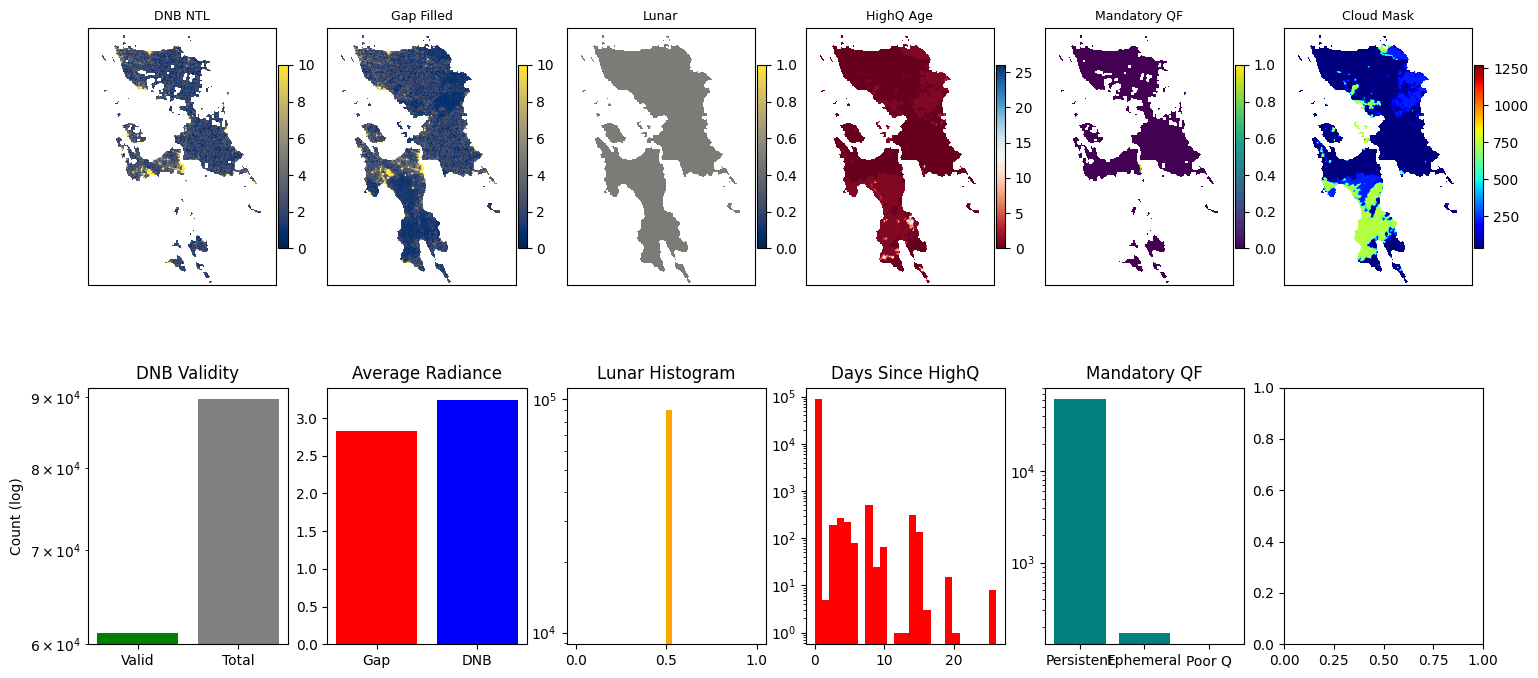

interactive(children=(Dropdown(description='Date:', options=(('Nov 01, 2013', 0), ('Nov 02, 2013', 1), ('Nov 0…

<function __main__.<lambda>(d)>

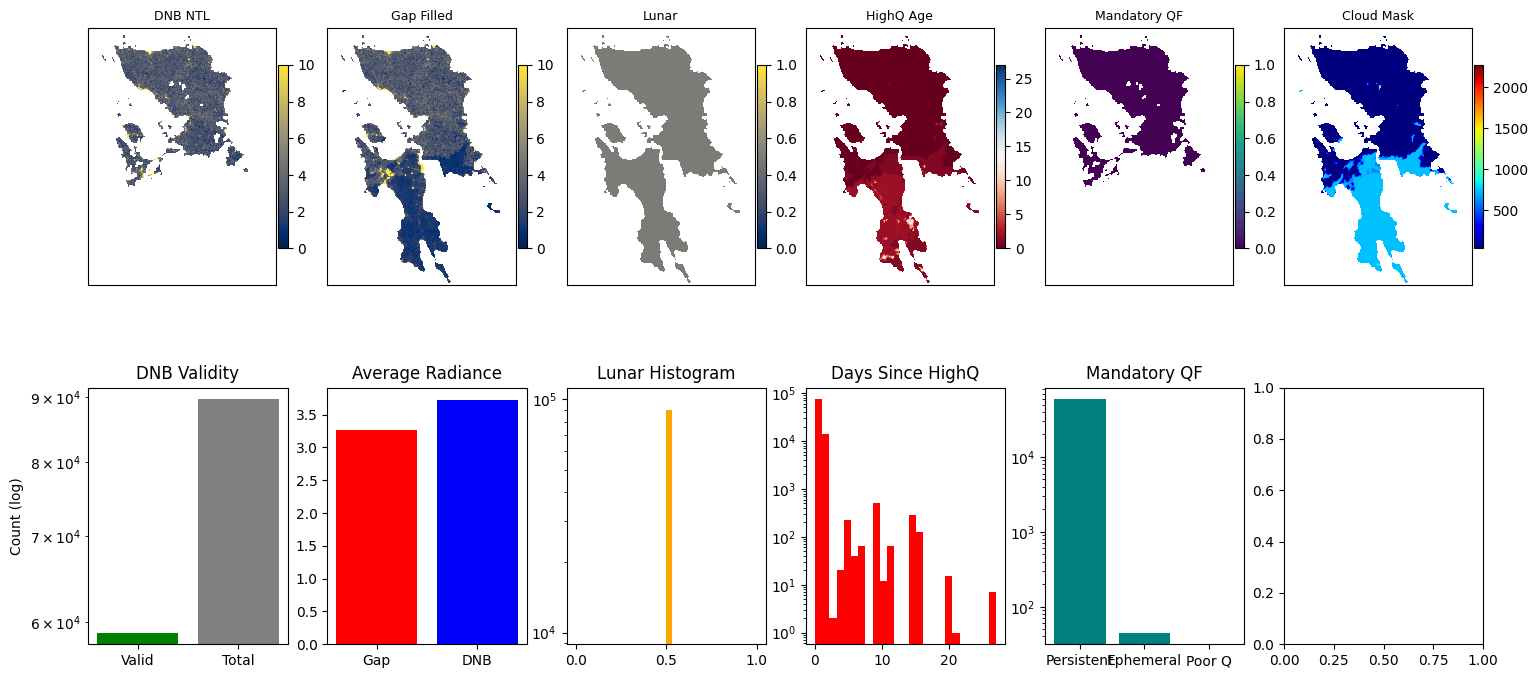

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# from ipywidgets import interact, Dropdown
# import rasterio
# from IPython.display import clear_output
# from datetime import datetime

# # --- Band Names ---
# band_names = [
#     'DNB_BRDF_Corrected_NTL',
#     'DNB_Lunar_Irradiance',
#     'Gap_Filled_DNB_BRDF_Corrected_NTL',
#     'Latest_High_Quality_Retrieval',
#     'Mandatory_Quality_Flag',
#     'QF_Cloud_Mask',
#     'Snow_Flag'
# ]

# def decode_qf_cloud_mask(mask):
#     return {'Confidence': (mask >> 6) & 0b11}

# def format_date(d): 
#     return datetime.strptime(d, "%Y%m%d").strftime("%b %d, %Y")

# def load_daily_data(folder):
#     tif_files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
#     data_list = []

#     for fname in tif_files:
#         date = fname[-12:-4]
#         with rasterio.open(os.path.join(folder, fname)) as src:
#             bands = src.read()
#             h, w = src.height, src.width
#             l, b, r, t = src.bounds
#             lons = np.linspace(l, r, w)
#             lats = np.linspace(t, b, h)
#             data_list.append({
#                 "date": date,
#                 "bands": bands,
#                 "lons": lons,
#                 "lats": lats,
#                 "extent": [lons[0], lons[-1], lats[-1], lats[0]]  # left, right, bottom, top
#             })

#     return data_list

# def plot_dashboard(data):
#     clear_output(wait=True)

#     bands = data['bands']
#     lons = data['lons']
#     lats = data['lats']
#     extent = data['extent']
#     date = data['date']

#     dnb = bands[0].astype(float) * 10
#     lunar = bands[1].astype(float)
#     gap = bands[2].astype(float) * 10
#     highq = bands[3].astype(float)
#     mandatory = np.where(bands[4] == 255, np.nan, bands[4].astype(float))
#     cloud = bands[5].astype(float)
#     mask = ~np.isnan(cloud)

#     fig = plt.figure(figsize=(18, 8))
#     gs = GridSpec(2, 6, figure=fig, hspace=0.4)

#     # --- TOP ROW HEATMAPS ---
#     heatmaps = [
#         (dnb, 'DNB NTL', 'cividis', 10),
#         (gap, 'Gap Filled', 'cividis', 10),
#         (lunar, 'Lunar', 'cividis', 1),
#         (highq, 'HighQ Age', 'RdBu', None),
#         (mandatory, 'Mandatory QF', 'viridis', None),
#         (cloud, 'Cloud Mask', 'jet', None)
#     ]

#     for i, (z, title, cmap, vmax) in enumerate(heatmaps):
#         ax = fig.add_subplot(gs[0, i])
#         img = ax.imshow(z, cmap=cmap, vmin=0 if vmax else None, vmax=vmax,
#                         extent=extent, origin='upper', aspect='auto')
#         ax.set_title(title, fontsize=9)
#         ax.set_xticks([]); ax.set_yticks([])
#         plt.colorbar(img, ax=ax, fraction=0.046, pad=0.01)

#     # --- BOTTOM ROW ---

#     # 1. DNB Validity
#     total = np.count_nonzero(mask)
#     valid = np.count_nonzero((dnb > 0) & mask)
#     ax = fig.add_subplot(gs[1, 0])
#     ax.bar(['Valid', 'Total'], [valid, total], color=['green', 'gray'])
#     ax.set_yscale('log'); ax.set_title('DNB Validity')
#     ax.set_ylabel('Count (log)')

#     # 2. Average Radiance
#     gap_valid = gap[mask & (gap > 0)]
#     dnb_valid = dnb[mask & (dnb > 0)]
#     ax = fig.add_subplot(gs[1, 1])
#     ax.bar(['Gap', 'DNB'], [np.mean(gap_valid), np.mean(dnb_valid)], color=['red', 'blue'])
#     ax.set_title('Average Radiance')

#     # 3. Lunar Histogram
#     ax = fig.add_subplot(gs[1, 2])
#     clean = lunar[mask]
#     ax.hist(clean[~np.isnan(clean)], bins=30, color='orange')
#     ax.set_yscale('log'); ax.set_title('Lunar Histogram')

#     # 4. HighQ Age Histogram
#     ax = fig.add_subplot(gs[1, 3])
#     clean = highq[mask]
#     ax.hist(clean[~np.isnan(clean)], bins=25, color='red')
#     ax.set_yscale('log'); ax.set_title('Days Since HighQ')

#     # 5. Mandatory QF
#     ax = fig.add_subplot(gs[1, 4])
#     vals = mandatory[mask]
#     vals = vals[~np.isnan(vals)]
#     labels = ['Persistent', 'Ephemeral', 'Poor Q']
#     bins = [0, 1, 2]
#     counts = [np.sum(vals == i) for i in bins]
#     ax.bar(labels, counts, color='teal')
#     ax.set_yscale('log'); ax.set_title('Mandatory QF')

#     # 6. Cloud Confidence
#     ax = fig.add_subplot(gs[1, 5])
#     conf = decode_qf_cloud_mask(cloud)['Confidence']
#     counts = [np.sum(conf == i) for i in range(4)]
#     ax.bar(range(4), counts, color='purple')
#     ax.set_xticks(range(4)); ax.set_xticklabels([str(i) for i in range(4)])
#     ax.set_yscale('log'); ax.set_title('Cloud Confidence')

#     fig.suptitle(f"VNP46A2 Dashboard — {format_date(date)}", fontsize=14)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

# # --- Load data & setup slider ---
# folder = "../Datasets/VNP46A2_AllBands_Nov2013/"
# daily_data = load_daily_data(folder)

# dropdown = Dropdown(
#     options=[(format_date(d["date"]), i) for i, d in enumerate(daily_data)],
#     description='Date:'
# )
# interact(lambda d: plot_dashboard(daily_data[d]), d=dropdown)

In [110]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# from celluloid import Camera
# import rasterio
# import mpld3
# from datetime import datetime

# # ------------------------
# # Configuration
# # ------------------------
# folder = "../Datasets/VNP46A2_AllBands_Nov2013/"

# band_names = [
#     'DNB_BRDF_Corrected_NTL',
#     'DNB_Lunar_Irradiance',
#     'Gap_Filled_DNB_BRDF_Corrected_NTL',
#     'Latest_High_Quality_Retrieval',
#     'Mandatory_Quality_Flag',
#     'QF_Cloud_Mask',
#     'Snow_Flag'
# ]

# def decode_qf_cloud_mask(mask):
#     return {'Confidence': (mask >> 6) & 0b11}

# def format_date(d): 
#     return datetime.strptime(d, "%Y%m%d").strftime("%b %d, %Y")

# def load_daily_data(folder):
#     tif_files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
#     data_list = []
#     for fname in tif_files:
#         date = fname[-12:-4]
#         with rasterio.open(os.path.join(folder, fname)) as src:
#             bands = src.read()
#             h, w = src.height, src.width
#             l, b, r, t = src.bounds
#             lons = np.linspace(l, r, w)
#             lats = np.linspace(t, b, h)
#             data_list.append({
#                 "date": date,
#                 "bands": bands,
#                 "lons": lons,
#                 "lats": lats,
#                 "extent": [lons[0], lons[-1], lats[-1], lats[0]]  # left, right, bottom, top
#             })
#     return data_list

# # ------------------------
# # Dashboard Drawing Logic
# # ------------------------
# def draw_dashboard(fig, gs, data):
#     bands = data['bands']
#     extent = data['extent']
#     date = data['date']

#     dnb = bands[0].astype(float) * 10
#     lunar = bands[1].astype(float)
#     gap = bands[2].astype(float) * 10
#     highq = bands[3].astype(float)
#     mandatory = np.where(bands[4] == 255, np.nan, bands[4].astype(float))
#     cloud = bands[5].astype(float)
#     mask = ~np.isnan(cloud)

#     # --- TOP ROW HEATMAPS ---
#     heatmaps = [
#         (dnb, 'DNB NTL', 'cividis', 10),
#         (gap, 'Gap Filled', 'cividis', 10),
#         (lunar, 'Lunar', 'cividis', 1),
#         (highq, 'HighQ Age', 'RdBu', None),
#         (mandatory, 'Mandatory QF', 'viridis', None),
#         (cloud, 'Cloud Mask', 'jet', None)
#     ]

#     for i, (z, title, cmap, vmax) in enumerate(heatmaps):
#         ax = fig.add_subplot(gs[0, i])
#         img = ax.imshow(z, cmap=cmap, vmin=0 if vmax is not None else None,
#                         vmax=vmax, extent=extent, origin='upper', aspect='equal')
#         ax.set_title(title, fontsize=9)
#         ax.set_xticks([]); ax.set_yticks([])
#         plt.colorbar(img, ax=ax, fraction=0.035, pad=0.02)

#     # --- BOTTOM ROW PLOTS ---

#     # 1. DNB Validity
#     total = np.count_nonzero(mask)
#     valid = np.count_nonzero((dnb > 0) & mask)
#     ax = fig.add_subplot(gs[1, 0])
#     ax.bar(['Valid', 'Total'], [valid, total], color=['green', 'gray'])
#     ax.set_yscale('log'); ax.set_title('DNB Validity')
#     ax.set_ylabel('Count (log)')

#     # 2. Avg Radiance
#     gap_valid = gap[mask & (gap > 0)]
#     dnb_valid = dnb[mask & (dnb > 0)]
#     ax = fig.add_subplot(gs[1, 1])
#     ax.bar(['Gap', 'DNB'], [np.mean(gap_valid), np.mean(dnb_valid)], color=['red', 'blue'])
#     ax.set_title('Average Radiance')

#     # 3. Lunar Histogram
#     ax = fig.add_subplot(gs[1, 2])
#     clean = lunar[mask]
#     ax.hist(clean[~np.isnan(clean)], bins=30, color='orange')
#     ax.set_yscale('log'); ax.set_title('Lunar Histogram')

#     # 4. HighQ Histogram
#     ax = fig.add_subplot(gs[1, 3])
#     clean = highq[mask]
#     ax.hist(clean[~np.isnan(clean)], bins=25, color='red')
#     ax.set_yscale('log'); ax.set_title('Days Since HighQ')

#     # 5. Mandatory QF
#     ax = fig.add_subplot(gs[1, 4])
#     vals = mandatory[mask]
#     vals = vals[~np.isnan(vals)]
#     labels = ['Persistent', 'Ephemeral', 'Poor Q']
#     bins = [0, 1, 2]
#     counts = [np.sum(vals == i) for i in bins]
#     ax.bar(labels, counts, color='teal')
#     ax.set_yscale('log'); ax.set_title('Mandatory QF')

#     # 6. Cloud Confidence
#     ax = fig.add_subplot(gs[1, 5])
#     conf = decode_qf_cloud_mask(cloud)['Confidence']
#     counts = [np.sum(conf == i) for i in range(4)]
#     ax.bar(range(4), counts, color='purple')
#     ax.set_xticks(range(4)); ax.set_xticklabels([str(i) for i in range(4)])
#     ax.set_yscale('log'); ax.set_title('Cloud Confidence')

#     fig.suptitle(f"VNP46A2 Dashboard — {format_date(date)}", fontsize=14)

# # ------------------------
# # Animate and Export
# # ------------------------
# def export_dashboard_animation(data_list, output_html="dashboard.html"):
#     fig = plt.figure(figsize=(18, 8))
#     gs = GridSpec(2, 6, figure=fig, hspace=0.4)
#     camera = Camera(fig)

#     for data in data_list:
#         draw_dashboard(fig, gs, data)
#         camera.snap()

#     anim = camera.animate()
#     html = mpld3.fig_to_html(fig)
#     with open(output_html, "w") as f:
#         f.write(html)

#     print(f"✅ HTML dashboard saved to {output_html}")

# # ------------------------
# # Run
# # ------------------------
# if __name__ == "__main__":
#     data = load_daily_data(folder)
#     export_dashboard_animation(data, output_html="VNP46A2_Dashboard.html")